## NYC taxi & timeit optimization

**Importing dataset from a zipped csv file**

In [1]:
import pandas as pd
nyc = pd.read_csv('nyc.csv.zip', compression='zip')

nyc.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


**Dataset description:**
    
    pickup_datetime — UTC
    pickup_longitude — ride starting point longitude
    pickup_latitude — ride starting point latitude
    dropoff_longitude — ride ending point longitude
    dropoff_latitude — ride ending point latitude
    fare_amount — ride cost
    passenger_count — number of passengers


**Calculate distance of each ride using provided coordinates. Add calculated distance to a new column.**

In [2]:
import numpy as np  # for math operations


def haversine(start_lng, start_lat, end_lng, end_lat, radius=6371):
    # converting coordinates to radians
    start_lng_rad = np.radians(start_lng)
    start_lat_rad = np.radians(start_lat)
    end_lng_rad = np.radians(end_lng)
    end_lat_rad = np.radians(end_lat)
    # this uses the ‘haversine’ formula to calculate the great-circle distance between two points (the shortest distance over the earth’s surface)
    distance = 2 * radius * np.arcsin((np.sin((end_lat_rad - start_lat_rad) / 2)**2 + np.cos(start_lat_rad) * np.cos(end_lat_rad) * np.sin((end_lng_rad - start_lng_rad) / 2)**2)**.5)
    return distance

# adding calculated distance to our dataframe    
dist = []
for i, row in nyc.iterrows():
    dist.append(haversine(row.pickup_longitude, row.pickup_latitude, row.dropoff_longitude, row.dropoff_latitude))
nyc['distance'] = dist

nyc.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


**There are couple ways to apply calculate distance function to our dataframe. Compare their execution time and find the most optimized way.**

In [ ]:
# using .iterrows() method

In [8]:
%%timeit
dist = []
for i, row in nyc.iterrows():
    dist.append(haversine(row.pickup_longitude, row.pickup_latitude, row.dropoff_longitude, row.dropoff_latitude))
nyc['distance'] = dist

9.83 s ± 572 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# using .itertuples() method

In [28]:
%%timeit
dist = []
for row in nyc.itertuples():
    dist.append(haversine(row.pickup_longitude, row.pickup_latitude, row.dropoff_longitude, row.dropoff_latitude))
nyc['distance'] = dist

846 ms ± 84.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# using .apply() to dataframe

In [29]:
%%timeit
nyc['distance'] = nyc.apply(lambda row: haversine(row.pickup_longitude, row.pickup_latitude, row.dropoff_longitude, row.dropoff_latitude), axis=1)

4.92 s ± 686 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# using apply to columns of dataframe

In [31]:
%%timeit
nyc['distance'] = nyc[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] \
    .apply(lambda row: haversine(row[0], row[1], row[2], row[3]), axis=1)

4.31 s ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# using vectorization

In [51]:
%%timeit
nyc['distance'] = haversine(nyc['pickup_longitude'], nyc['pickup_latitude'], nyc['dropoff_longitude'], nyc['dropoff_latitude'])

10.4 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# applying vectorization directly to values

In [5]:
%%timeit
nyc['distance'] = haversine(nyc['pickup_longitude'].values, nyc['pickup_latitude'].values, nyc['dropoff_longitude'].values, nyc['dropoff_latitude'].values)

3.86 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Plotting the execution time comparison results**

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

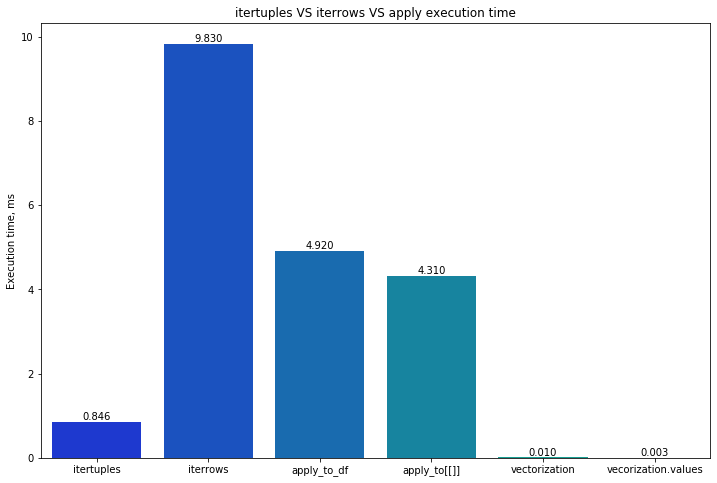

In [15]:
plt.figure(figsize=(12, 8))
graph = sns.barplot(palette='winter', x=['itertuples', 'iterrows', 'apply_to_df', 'apply_to[[]]', 'vectorization', 'vecorization.values'], y=[0.846, 9.83, 4.92, 4.31, 0.0104, 0.00347])
plt.title('itertuples VS iterrows VS apply execution time');
plt.ylabel('Execution time, ms')

# showing values on top of bars
for p in graph.patches:
        graph.annotate('{:.3f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

**Checking the calculated distance statistics**

In [17]:
nyc.distance.describe()

count    50000.000000
mean        18.508946
std        355.564309
min          0.000000
25%          1.223146
50%          2.120114
75%          3.895570
max       8667.818812
Name: distance, dtype: float64

In [ ]:
# Max distance of 8667 km looks odd for a taxi ride. Let's find the reason!

**Finding rows with zero pick-up coordinates**

In [23]:
nyc.query('pickup_latitude == 0 or pickup_longitude == 0')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
11,2012-12-24 11:24:00.00000098,5.5,2012-12-24 11:24:00 UTC,0.0,0.0,0.0,0.0,3,0.0
15,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00 UTC,0.0,0.0,0.0,0.0,1,0.0
26,2011-02-07 20:01:00.000000114,6.5,2011-02-07 20:01:00 UTC,0.0,0.0,0.0,0.0,1,0.0
124,2013-01-17 17:22:00.00000043,8.0,2013-01-17 17:22:00 UTC,0.0,0.0,0.0,0.0,2,0.0
192,2010-09-05 17:08:00.00000092,3.7,2010-09-05 17:08:00 UTC,0.0,0.0,0.0,0.0,5,0.0
...,...,...,...,...,...,...,...,...,...
49625,2012-01-09 19:50:27.0000001,12.1,2012-01-09 19:50:27 UTC,0.0,0.0,0.0,0.0,1,0.0
49816,2012-02-20 00:54:00.000000100,4.9,2012-02-20 00:54:00 UTC,0.0,0.0,0.0,0.0,1,0.0
49845,2009-03-02 21:57:15.0000001,6.6,2009-03-02 21:57:15 UTC,0.0,0.0,0.0,0.0,3,0.0
49856,2010-04-19 17:25:00.000000170,10.9,2010-04-19 17:25:00 UTC,0.0,0.0,0.0,0.0,5,0.0


**Finding rows with zero drop-off coordinates**

In [22]:
nyc.query('dropoff_latitude == 0 or dropoff_longitude == 0')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
11,2012-12-24 11:24:00.00000098,5.5,2012-12-24 11:24:00 UTC,0.0,0.0,0.0,0.0,3,0.0
15,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00 UTC,0.0,0.0,0.0,0.0,1,0.0
26,2011-02-07 20:01:00.000000114,6.5,2011-02-07 20:01:00 UTC,0.0,0.0,0.0,0.0,1,0.0
124,2013-01-17 17:22:00.00000043,8.0,2013-01-17 17:22:00 UTC,0.0,0.0,0.0,0.0,2,0.0
192,2010-09-05 17:08:00.00000092,3.7,2010-09-05 17:08:00 UTC,0.0,0.0,0.0,0.0,5,0.0
...,...,...,...,...,...,...,...,...,...
49625,2012-01-09 19:50:27.0000001,12.1,2012-01-09 19:50:27 UTC,0.0,0.0,0.0,0.0,1,0.0
49816,2012-02-20 00:54:00.000000100,4.9,2012-02-20 00:54:00 UTC,0.0,0.0,0.0,0.0,1,0.0
49845,2009-03-02 21:57:15.0000001,6.6,2009-03-02 21:57:15 UTC,0.0,0.0,0.0,0.0,3,0.0
49856,2010-04-19 17:25:00.000000170,10.9,2010-04-19 17:25:00 UTC,0.0,0.0,0.0,0.0,5,0.0


**Visualize coordinates on boxplot to check for outliers**

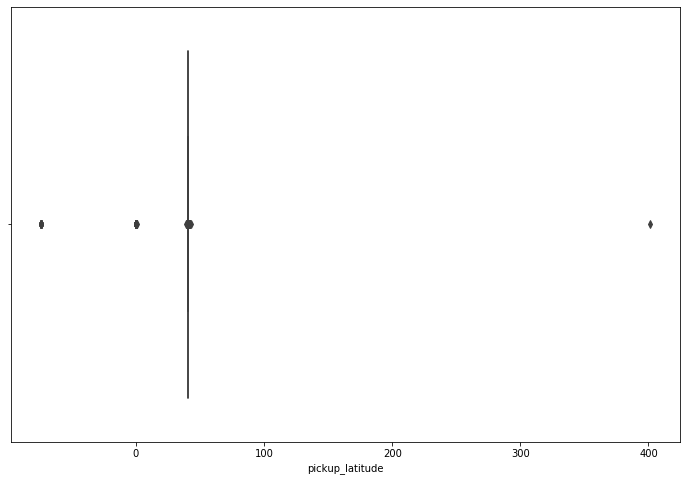

In [26]:
# Pick-up latitude
plt.figure(figsize=(12,8))
sns.boxplot(nyc.pickup_latitude);

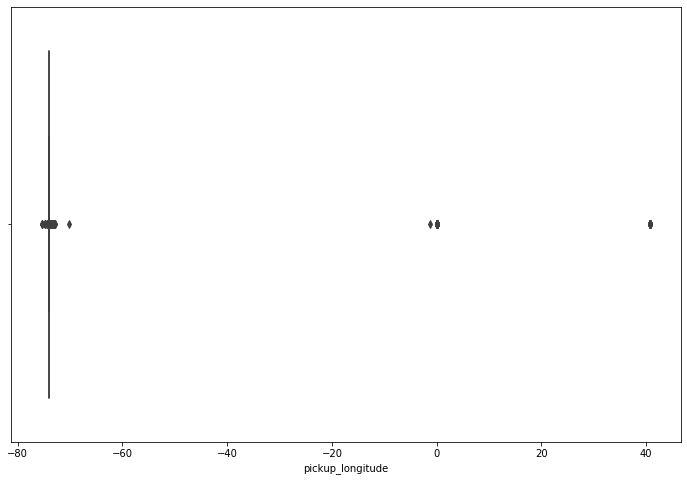

In [25]:
# Pick-up longitude
plt.figure(figsize=(12,8))
sns.boxplot(nyc.pickup_longitude);

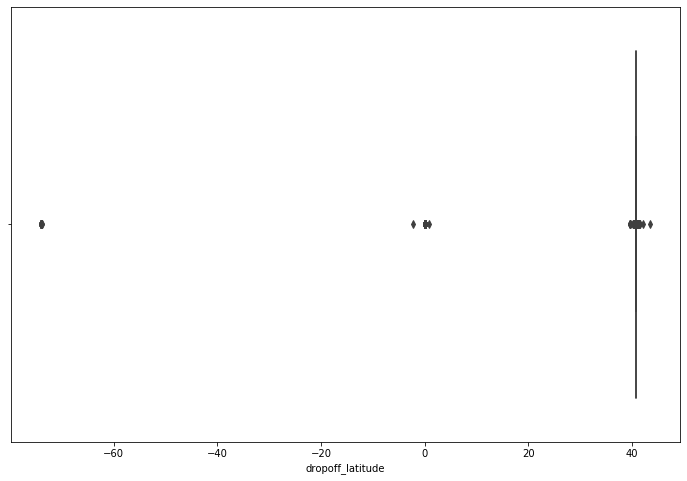

In [27]:
# Drop-off latitude
plt.figure(figsize=(12,8))
sns.boxplot(nyc.dropoff_latitude);

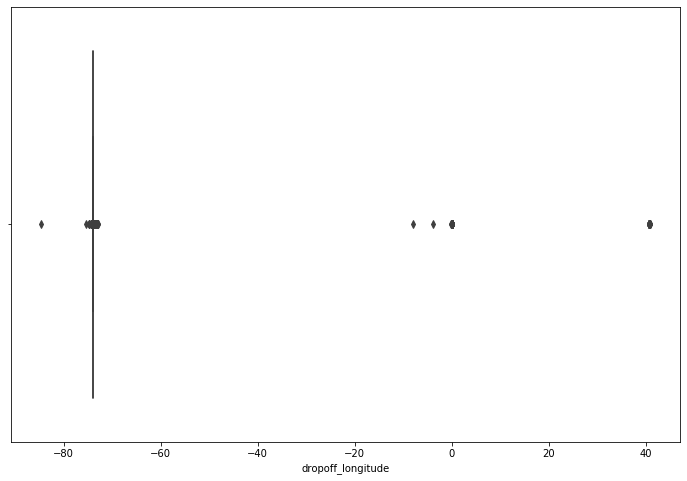

In [29]:
# Drop-off longitude
plt.figure(figsize=(12,8))
sns.boxplot(nyc.dropoff_longitude);

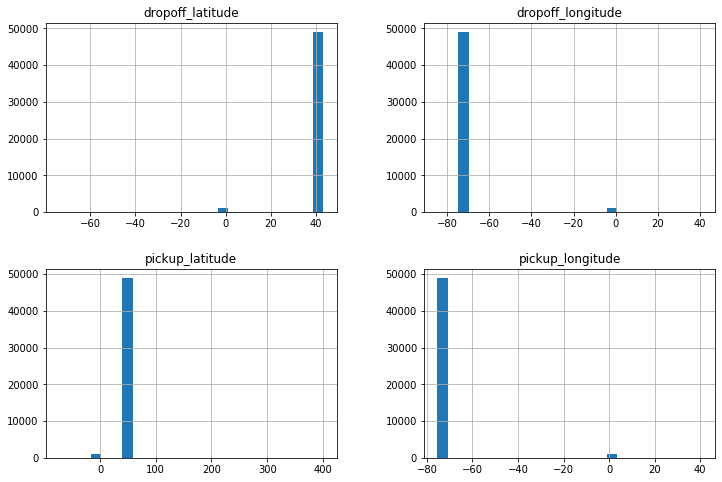

In [7]:
# Alternative solution to spot outliers
nyc[['pickup_longitude', 
     'pickup_latitude', 
     'dropoff_longitude', 
     'dropoff_latitude']].hist(figsize=(12, 8), bins=25);

**With help of boxplots we've found ranges to filter our data and remove coordinates outliers**

In [36]:
longest_ride_df = nyc.query('pickup_longitude < -60') \
                     .query('pickup_latitude < 120') \
                     .query('pickup_latitude > 10') \
                     .query('dropoff_latitude > 10') \
                     .query('dropoff_longitude < -60') \
                     .query('distance < 50')  # all city rides are in 50 km range due to terms of service use

longest_ride_df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157
...,...,...,...,...,...,...,...,...,...
49995,2013-06-12 23:25:15.0000004,15.0,2013-06-12 23:25:15 UTC,-73.999973,40.748531,-74.016899,40.705993,1,4.940374
49996,2015-06-22 17:19:18.0000007,7.5,2015-06-22 17:19:18 UTC,-73.984756,40.768211,-73.987366,40.760597,1,0.874706
49997,2011-01-30 04:53:00.00000063,6.9,2011-01-30 04:53:00 UTC,-74.002698,40.739428,-73.998108,40.759483,1,2.263286
49998,2012-11-06 07:09:00.00000069,4.5,2012-11-06 07:09:00 UTC,-73.946062,40.777567,-73.953450,40.779687,2,0.665245


**Checking distance statistics after removing wrong coordinates**

In [34]:
longest_ride_df.distance.describe()

count    48944.000000
mean         3.329111
std          3.593511
min          0.000000
25%          1.262826
50%          2.158081
75%          3.934387
max         44.746988
Name: distance, dtype: float64

In [ ]:
# Now distance distribution looks to be okay.

**Find the cost of the longest distance ride**

In [60]:
max_cost = longest_ride_df.sort_values('distance', ascending=False).head(1).fare_amount.iloc[0]

print(f'The cost of the longest ride is {max_cost:.2f} USD.')

The cost of the longest ride is 136.00 USD.
